In [15]:
import pathlib
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pathlib
from GPy.models import GPRegression
import GPy
import pickle
import matplotlib.colors as mcolors
from sklearn.neighbors import KernelDensity
import sys
sys.path.append("./../")
import random
from src.utils import load_data, prep_data, predict_and_plot_SLC
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from scipy.stats import wasserstein_distance
import seaborn as sns
plt.style.use('seaborn-whitegrid')
sns.set_palette('colorblind')
mpl.rcParams['font.family'] = 'Arial'

In [ ]:
# Figure 5

def run(data, sample_size):
    thres = 90
    full_res_cdf = []
    full_res = []
    x_time = list(range(0,175,2))
    for timestamp in tqdm(x_time):
        pred = [predict_and_plot_SLC(data, timestamp, 600, i, plot=False, sample_size=sample_size) for i in range(2,9)]

        Y_result = []
        Y_result_cdf = []
        for i in pred:
            mean,var = i[1]
            data_list = []
            for m,v in zip(mean,var):
                data_list += list(np.random.normal(m,np.sqrt(v),size=sample_size))
                
            X_lin = np.linspace(0,800,1000)[:, np.newaxis]
            kde = KernelDensity(kernel='gaussian',bandwidth=1).fit(np.array(data_list).reshape((-1,1))) #you can supply a bandwidth
            log_density_values=kde.score_samples(X_lin)
            Y_opt=np.exp(log_density_values)
            Y_result.append(Y_opt)

            y = []
            for thres in range(0,800,5):
                # Count how many elements in data list are abov thres
                # and divide by the total number of elements
                # to get the percentage of elements above thres
                y.append(len([i for i in data_list if i > thres])/len(data_list))

            Y_result_cdf.append(y)
        full_res.append(Y_result)
        full_res_cdf.append(Y_result_cdf)
    pickle.dump(full_res, open("./../assets/plots_data/fig_5_pdf.pkl", "wb"))
    pickle.dump(full_res_cdf, open("./../assets/plots_data/fig_5_cdf.pkl", "wb"))
    return full_res, full_res_cdf

In [16]:
# Load data 
# If you want to re-run the simulation

use_cached_data = True
if use_cached_data:
    full_res = pickle.load(open("./../assets/plots_data/fig_5_pdf.pkl", "rb"))
    full_res_cdf = pickle.load(open("./../assets/plots_data/fig_5_cdf.pkl", "rb"))
else:
    data = load_data([0,176])
    sample_size = 500 # TEST SIZE, if you want real plots s=3000
    full_res, full_res_cdf = run(data, sample_size)


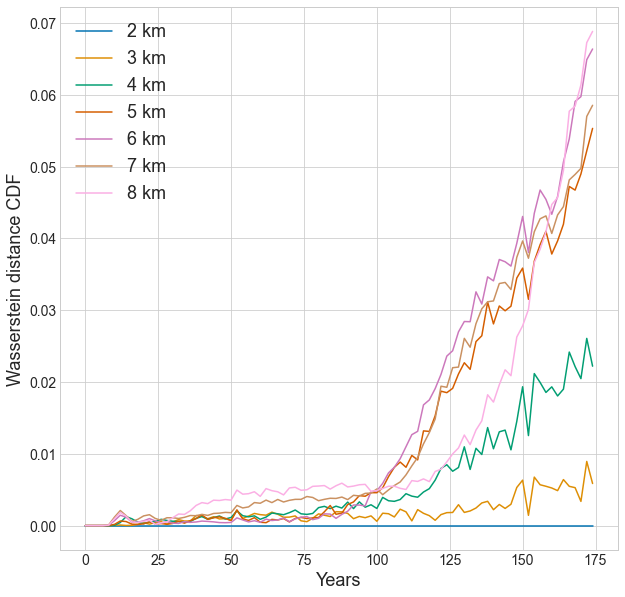

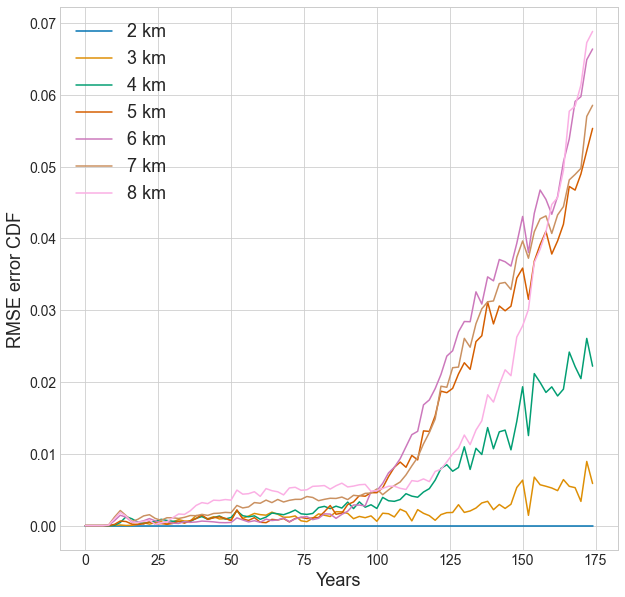

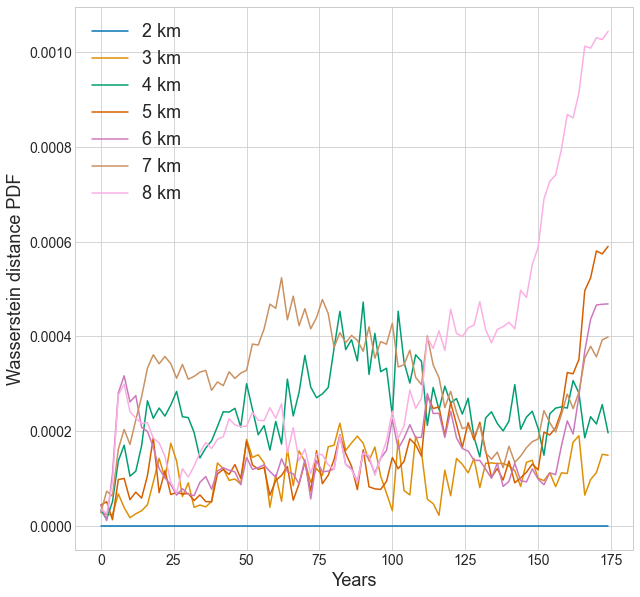

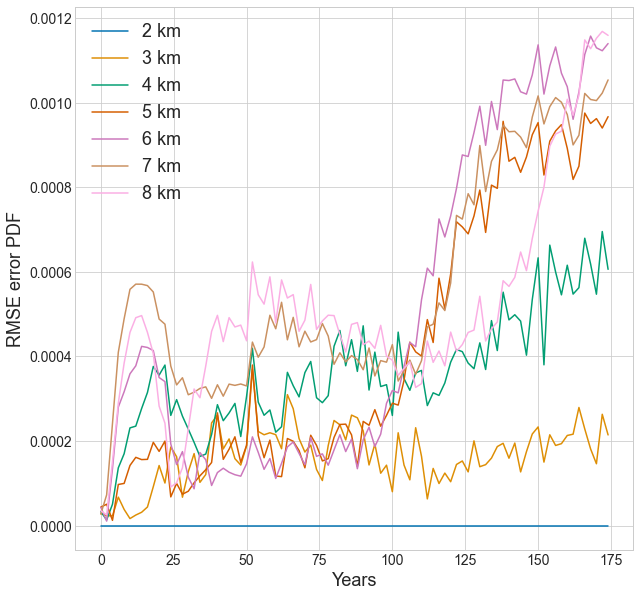

In [18]:
x_time = list(range(0,175,2))
for density in ["CDF", "PDF"]:
    if density == "CDF":
        prob_data = full_res_cdf
    else:
        prob_data = full_res

    wasserstein_error = []
    rmse_error = []

    for i in range(len(full_res)):
        wasserstein_error.append([wasserstein_distance(prob_data[i][0], n) for n in prob_data[i]])
        rmse_error.append([np.abs(prob_data[i][0] - np.array(n)).mean() for n in prob_data[i]])

    cutoff = 90
    for err_list, label in zip([wasserstein_error, rmse_error],[f"Wasserstein distance {density}", f"RMSE error {density}"]):
        err = np.array(err_list)
        plt.figure(figsize=(10,10))
        for i in range(err.shape[1]):
            plt.plot(x_time[:cutoff],err[:cutoff,i],label=str(range(2,9)[i])+" km")
        plt.legend(fontsize=18)
        plt.xlabel("Years",fontsize=18)
        plt.ylabel(label,fontsize=18)

        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        #plt.title("Error over time")
        # Save as pdf
        plt.savefig(f"./../assets/plots/fig_5/{label}_error_{density}.pdf",bbox_inches='tight')
        #plt.show()